# Clean Text Data

In [ ]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [2]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [124]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    if isinstance(x, float):
        return 0
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = x
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = x
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    if dt.datetime.strptime(fomc_calendar.index[0], '%Y-%m-%d') > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < dt.datetime.strptime(fomc_calendar.index[i], '%Y-%m-%d'):
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = x
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [134]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip() if not isinstance(x, float) else []),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]") if not isinstance(x, float) else []),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    #new_df['decision'] = new_df['decision'].astype('Int8')
    #new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [71]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    #split_df['decision'] = split_df['decision'].astype('Int8')
    #split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [6]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [7]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2023,12,14)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2023-12-14


### Load Calendar

In [9]:
fomc_calendar = pd.read_csv("../data/preprocessed/fomc_calendar.csv", index_col=0)

print(fomc_calendar.shape)
fomc_calendar.head()

(406, 7)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1.0
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1.0
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0.0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0.0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0.0


In [ ]:
# #Check caleander
# fomc_calendar.loc[fomc_calendar.index >= dt.datetime(1998, 1, 27)]

### Statement

In [32]:

statement_df = pd.read_csv("../data/dataset/FOMC/statement.csv", index_col=0)

print(statement_df.shape)
statement_df.head()

(201, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


In [ ]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

### Meeting Minutes

In [11]:
minutes_df = pd.read_csv("../data/dataset/FOMC/minutes.csv", index_col=0)

print(minutes_df.shape)
minutes_df.head()

(229, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [ ]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

### Meeting Transcripts

In [12]:
meeting_script_df = pd.read_csv("../data/dataset/FOMC/meeting_script.csv", index_col=0)

print(meeting_script_df.shape)
meeting_script_df.head()

(282, 4)


,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excu...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us to...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes.\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\...",other,FOMC Meeting Transcript


In [ ]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

### Press Conference Transcripts

In [13]:
presconf_script_df = pd.read_csv("../data/dataset/FOMC/presconf_script.csv", index_col=0)

print(presconf_script_df.shape)
presconf_script_df.head()

(55, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",Ben Bernanke,FOMC Press Conference Transcript


In [ ]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

### Speech

In [14]:
speech_df = pd.read_csv("../data/dataset/FOMC/speech.csv", index_col=0)

print(speech_df.shape)
speech_df.head()

(1607, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business


In [ ]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

### Testimony

In [15]:
testimony_df = pd.read_csv("../data/dataset/FOMC/testimony.csv", index_col=0)

print(testimony_df.shape)
testimony_df.head()

(456, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations


In [ ]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

## Statements DataFrame

In [20]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [33]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df.loc[statement_df.index[-1]+1] = ['2008-11-25', qe_text, 'Ben Bernanke', 'FOMC statement']

In [36]:
statement_df.tail()

,date,contents,speaker,title
197,2022-06-15,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
198,2022-07-27,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
199,2022-09-21,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
200,2022-11-02,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
201,2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,FOMC statement


### Process the dataframe

In [61]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  3
Shape of the dataframe:  (202, 13)


In [62]:
# Check the returned dataframe
proc_statement_df.iloc[-1, 5] = -1 # hardcode this data which had a wierd formatting
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,0.0,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.5,1994-04-18,1.0,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,1.0,4.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1.0,4.25,1994-07-06,0.0,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1.0,4.75,1994-09-27,0.0,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2022-06-15,FOMC Statement,other,527,1.0,1.5,2022-07-27,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and fin

In [66]:
# Check which row does not have rate
proc_statement_df.iloc[-1, 6] = 0 # hardcode this data which had a wierd formatting
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
198,statement,2022-07-27,FOMC Statement,other,474,NaN,NaN,2022-09-21,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
199,statement,2022-09-21,FOMC Statement,other,475,NaN,NaN,2022-11-02,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
200,statement,2022-11-02,FOMC Statement,other,544,NaN,NaN,None,None,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."


In [67]:
x = '2019-01-01'
fomc_calendar.loc[fomc_calendar.index > x]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
2019-01-30,False,False,False,Jerome Powell,2.25,0.00,0.0
2019-03-20,False,True,False,Jerome Powell,2.25,0.00,0.0
2019-05-01,False,False,False,Jerome Powell,2.25,0.00,0.0
2019-06-19,False,True,False,Jerome Powell,2.25,0.00,0.0
2019-07-31,False,False,False,Jerome Powell,2.00,-0.25,-1.0
...,...,...,...,...,...,...,...
2022-05-04,False,False,False,Jerome Powell,0.75,0.50,1.0
2022-06-15,False,True,False,Jerome Powell,1.50,0.75,1.0
2022-07-27,False,False,False,Jerome Powell,NaN,NaN,NaN


In [68]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


  0%|          | 0/202 [00:00<?, ?it/s]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,0.0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.5,1994-04-18,1.0,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,1.0,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1.0,4.25,1994-07-06,0.0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1.0,4.75,1994-09-27,0.0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2022-06-15,FOMC Statement,other,314,1.0,1.5,2022-07-27,NaN,NaN,The invasion of Ukraine by Russia is causing tremendous human and economic hardship. The invasion and related events are creating additional upward pressure on inflation and are weighing on global...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stabl

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

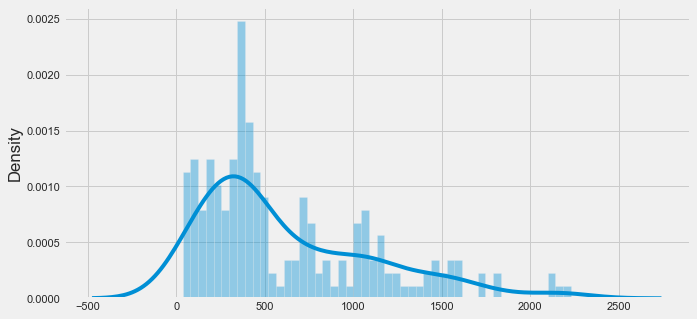

In [69]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [72]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

  0%|          | 0/202 [00:00<?, ?it/s]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
875,statement,2022-03-16,FOMC Statement,other,102,1.0,0.25,2022-05-04,1.0,0.75,goals The Committee's assessments will take into account a wide range of information including readings on public health labor market conditions inflation pressures and inflation expectations and ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
876,statement,2022-05-04,FOMC Statement,other,200,1.0,0.75,2022-06-15,1.0,1.5,Although overall economic activity edged down in the first quarter household spending and business fixed investment remained strong Job gains have been robust in recent months and the unemployment...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
877,statement,2022-05-04,FOMC Statement,other,169,1.0,0.75,2022-06-15,1.0,1.5,to its percent objective and the labor market to remain strong In support of these goals the Committee decided to raise the target range for the federal funds rate to to percent and anticipates th...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
878,statement,2022-06-15,FOMC Statement,other,200,1.0,1.50,2022-07-27,NaN,NaN,The invasion of Ukraine by Russia is causing tremendous human and economic hardship The invasion and related events are creating additional upward pressure on inflation and are weighing on global ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
879,statement,2022-06-15,FOMC Statement,other,164,1.0,1.50,2022-07-27,NaN,NaN,to returning inflation to its percent objective In assessing the appropriate stance of monetary policy the Committee will continue to monitor the implications of incoming information for the econo...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
880,statement,2022-07-27,FOMC Statement,other,182,NaN,NaN,2022-09-21,NaN,NaN,The Committee seeks to achieve maximum employment and inflation at the rate of percent over the longer run In support of these goals the Committee decided to raise the target range for the federal...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
881,state

### Filter out by keywords

In [73]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

(106, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1.0,4.25,1994-07-06,0.0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1.0,5.5,1994-12-20,0.0,5.5,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1.0,5.25,1996-03-26,0.0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1.0,5.5,1997-05-20,0.0,5.5,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1.0,5.25,1998-10-15,-1.0,5.0,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,statement,2021-07-28,FOMC Statement,Jerome Powell,223,0.0,0.0,2021-09-22,0.0,0.0,"The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation having run persistently below this longer-run goal, the Committee will ...","[The path of the economy continues to depend on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public heal

In [74]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [75]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [76]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  2
Shape of the dataframe:  (229, 13)


In [77]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0.0,3.00,1993-02-18,0.0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0.0,3.00,1993-05-18,0.0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0.0,3.00,1993-07-07,0.0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0.0,3.00,1993-08-17,0.0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0.0,3.00,1993-09-21,0.0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2022-03-16,FOMC Meeting Minutes,other,8556,1.0,0.25,2022-05-04,1.0,0.75,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the ce

In [78]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
227,minutes,2022-07-27,FOMC Meeting Minutes,other,8337,NaN,NaN,2022-09-21,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
228,minutes,2022-09-21,FOMC Meeting Minutes,other,7717,NaN,NaN,2022-11-02,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

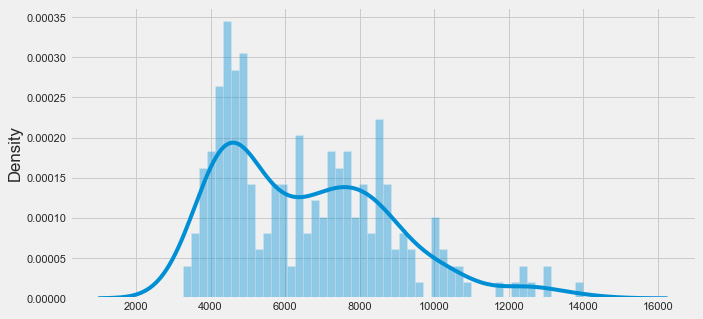

In [79]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [80]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
227,minutes,2022-07-27,FOMC Meeting Minutes,other,8337,NaN,NaN,2022-09-21,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
228,minutes,2022-09-21,FOMC Meeting Minutes,other,7717,NaN,NaN,2022-11-02,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [81]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [82]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [83]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

  0%|          | 0/229 [00:00<?, ?it/s]

### Split contents to max 200 words

In [84]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)

  0%|          | 0/229 [00:00<?, ?it/s]

(8586, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8576,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,the Committee's percent objective with many stressing the importance of staying on this course even as the labor market slowed In discussing potential policy actions at upcoming meetings participa...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8577,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,to depend on the implications of incoming information for the outlook for economic activity and inflation and on risks to the outlook Several participants noted that particularly in the current hi...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8578,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,with the Committee's Plans for Reducing the Size of the Federal Reserve's Balance Sheet balance sheet runoff had moved up to its maximum planned pace in September and would continue at that pace T...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8579,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,keep inflation expectations anchored at levels consistent with that longer run goal Participants noted that the Committee's commitment to restoring price stability together with its purposeful pol...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8580,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,trend rate very likely accompanied by some softening in labor market conditions was required They agreed that by moving its policy purposefully toward an appropriately restrictive stance the Commi...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8581,minutes,2022-09-21,FOMC Meeting Minutes,other,200,NaN,NaN,2022-11-02,NaN,NaN,of taking too much action Several participants underlined the need to maintain a restrictive stance for as long as necessary with a couple of these participants stressing that historical experienc...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\

### Filter out by keywords

In [85]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

(229, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,0.0,3.00,1993-02-18,0.0,3.0,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,0.0,3.00,1993-05-18,0.0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,0.0,3.00,1993-07-07,0.0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,0.0,3.00,1993-08-17,0.0,3.0,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,0.0,3.00,1993-09-21,0.0,3.0,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2022-03-16,FOMC Meeting Minutes,other,1426,1.0,0.25,2022-05-04,1.0,0.75,The manager turned next to a discussion of money markets and policy implementation. Market participants expected the interest on reserve balances rate and overnight reverse repurchase agreement (O...,[The manager turned next to a discussion of money markets and policy implementation. Market participants expected the interest on reserve balances rate and overnight reverse repurch

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

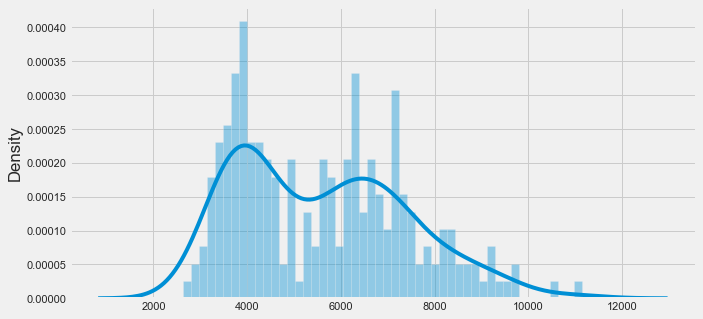

In [86]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [87]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [88]:
# Sample
print(presconf_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [89]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  3
Shape of the dataframe:  (55, 13)


In [90]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8763,0.0,0.00,2011-06-22,0.0,0.0,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7364,0.0,0.00,2011-08-01,0.0,0.0,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...","[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7360,0.0,0.00,2011-11-28,0.0,0.0,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to tak...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10135,0.0,0.00,2012-03-13,0.0,0.0,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7675,0.0,0.00,2012-06-20,0.0,0.0,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in t...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,presconf_script,2022-05-04,FOMC Press Conference Transcript,other,8187,1.0,0.75,2022-06-15,1.0,1.5,"CHAIR POWELL. Good afternoon. It’s nice to see everyone in person for the first time in a couple years. directly to the American people. Before I go into the details of today’s meeting, I’d like...","[CHAIR POWEL

In [91]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
52,presconf_script,2022-07-27,FOMC Press Conference Transcript,other,9806,NaN,NaN,2022-09-21,NaN,NaN,"CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down, and we’re moving expeditiously to do so. We have both the tools we need and the resolve...","[CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down, and we’re moving expeditiously to do so. We have both the tools we need and the resolv...","CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down, and we’re moving expeditiously to do so. We have both the tools we need and the resolve..."
53,presconf_script,2022-09-21,FOMC Press Conference Transcript,other,7249,NaN,NaN,2022-11-02,NaN,NaN,CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools we need and the resolve that it will take ...,[CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools we need and the resolve that it will take...,CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools we need and the resolve that it will take ...
54,presconf_script,2022-11-02,FOMC Press Conference Transcript,other,7767,NaN,NaN,None,NaN,NaN,PRELIMINARY Transcript of Chair Powell’s Press Conference [SECTION]CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal...,"[PRELIMINARY Transcript of Chair Powell’s Press Conference , CHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We ...",PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [92]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

0it [00:00, ?it/s]

not matched:  And COVID-related lockdowns in China are likely to exacerbate supply chain disruptions.  FOMC participants have revised up their projections for inflation this year, particularly for total  June 15, 2022    Chair Powell’s Press Conference  FINAL PCE inflation given developments in food and energy prices.  The median projection is 5.2 percent this year and falls to 2.6 percent next year and 2.2 percent in 2024.  Participants continue to see risks to inflation as weighted to the upside. The Fed’s monetary policy actions are guided by our mandate to promote maximum employment and stable prices for the American people.  My colleagues and I are acutely aware that high inflation imposes significant hardship, especially on those least able to meet the higher costs of essentials like food, housing, and transportation.  We are highly attentive to the risks high inflation poses to both sides of our mandate, and we are strongly committed to returning inflation to our 2 percent obje

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1617,0.0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,64,0.0,0.0,2011-06-22,0.0,0.0,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,198,0.0,0.0,2011-06-22,0.0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0.0,0.0,2011-06-22,0.0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,322,0.0,0.0,2011-06-22,0.0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,presconf_script,2022-11-02,FOMC Press Conference Transcript,CHAIR POWELL,41,NaN,NaN,None,NaN,NaN,"Has it narrowed? Yes. Is it still possible? Yes. I think, we've always said it was going to be difficult, but I think to the extent rates have to go higher and stay higher November 2, 2022 Chair ...","[PRELIMINARY T

In [93]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(2121, 13)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

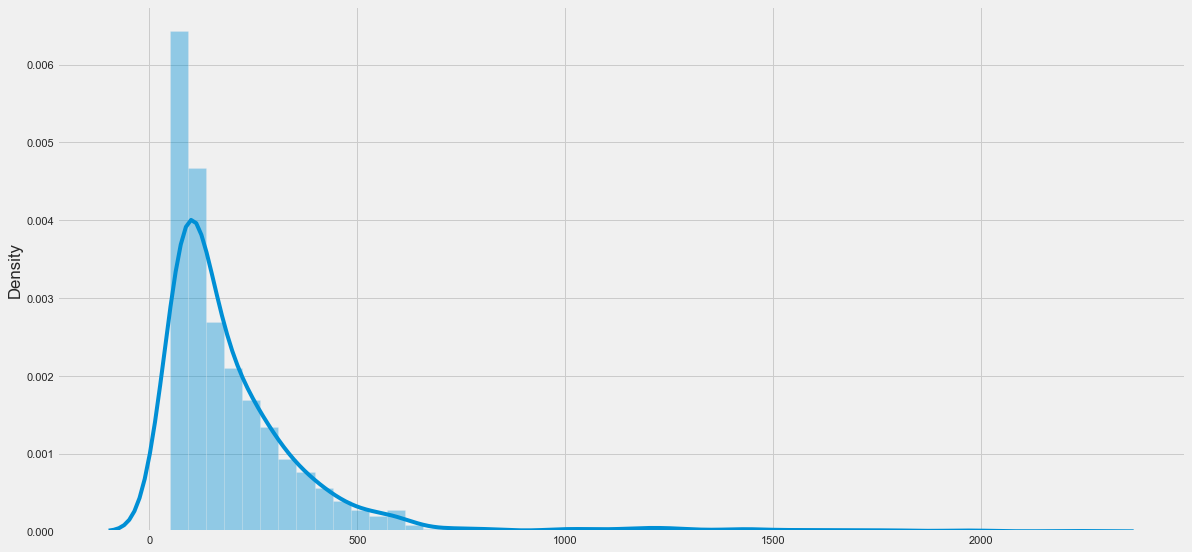

In [94]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [100]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson!=None and chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1617,0.0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,198,0.0,0.0,2011-06-22,0.0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,322,0.0,0.0,2011-06-22,0.0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,207,0.0,0.0,2011-06-22,0.0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,166,0.0,0.0,2011-06-22,0.0,0.0,"Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, dur...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,292,NaN,NaN,None,NaN,NaN,"Well what's happened is time has passed and we've raised interest rates by 375 basis points. I would not, I would not change a word in that statement though. I think until we get inflation down, y...","[PRELIMINARY Tran

In [101]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1235, 13)


0it [00:00, ?it/s]

After (55, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7505,0.0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
21,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,6002,0.0,0.0,2011-08-01,0.0,0.0,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy stra...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
40,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5875,0.0,0.0,2011-11-28,0.0,0.0,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
62,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7970,0.0,0.0,2012-03-13,0.0,0.0,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And f...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
81,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5855,0.0,0.0,2012-06-20,0.0,0.0,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our ec...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

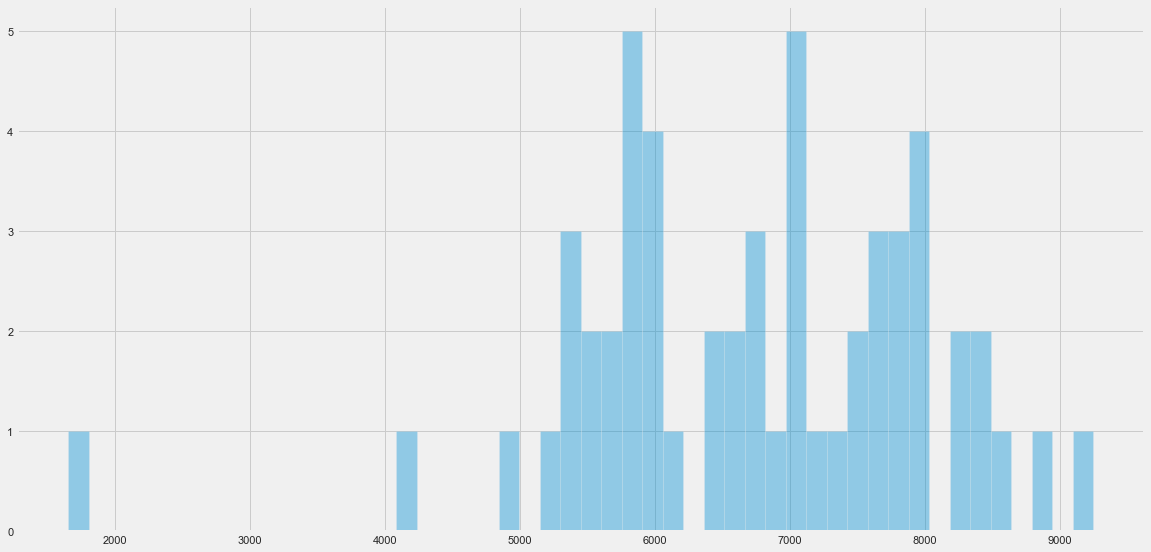

In [102]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [ ]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [103]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()

  0%|          | 0/55 [00:00<?, ?it/s]

(2476, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
2471,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,200,NaN,NaN,None,NaN,NaN,still in the pipeline there's still some significant rate increases coming Okay But at some point once you get through that the new leases are going to tell you what they re telling you is there w...,[Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools that we need and the resolve it will take to restore pri...,PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...
2472,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,200,NaN,NaN,None,NaN,NaN,that we think we have a ways to go we have some ground to cover with interest rates before we get to before we get to that level of interest rates that we think is sufficiently restrictive And put...,[Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools that we need and the resolve it will take to restore pri...,PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...
2473,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,200,NaN,NaN,None,NaN,NaN,down it just if you look at the I have a table of the last months of month readings and there's really no pattern there We re exactly where we were a year ago So okay so I would also say it's prem...,[Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools that we need and the resolve it will take to restore pri...,PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...
2474,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,200,NaN,NaN,None,NaN,NaN,pretty significant demand and a tightening labor market in some respects although I think overall I would say it's not really tightening or loosening So we see those things and what those things t...,[Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools that we need and the resolve it will take to restore pri...,PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...
2475,presconf_script,2022-11-02,FOMC Press Conference Transcript,Jerome Powell,60,NaN,NaN,None,NaN,NaN,it has come down but it's not to the extent that we had hoped At the same time now you see services inflation core services inflation moving up and I just think that the inflation picture has beco...,[Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 percent goal. We have both the tools that we need and the resolve it will take to restore pri...,PRELIMINARY Transcript of Chair Powell’s Press Conference \n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2 perc...


### Filter out by keywords

In [104]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

(55, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3758,0.0,0.00,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projectio...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2322,0.0,0.00,2011-08-01,0.0,0.0,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy strat...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2432,0.0,0.00,2011-11-28,0.0,0.0,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. A...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,5123,0.0,0.00,2012-03-13,0.0,0.0,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And fi...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2178,0.0,0.00,2012-06-20,0.0,0.0,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our eco...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,presconf_script,2022-05-04,FOMC Press Conference Transcript,Jerome Powell,3547,1.0,0.75,2022-06-15,1.0,1.5,"Good afternoon. It’s nice to see everyone in person for the first time in a couple years. directly to the American people. Before I go into the details of today’s meeting, I’d like to take this o...",

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

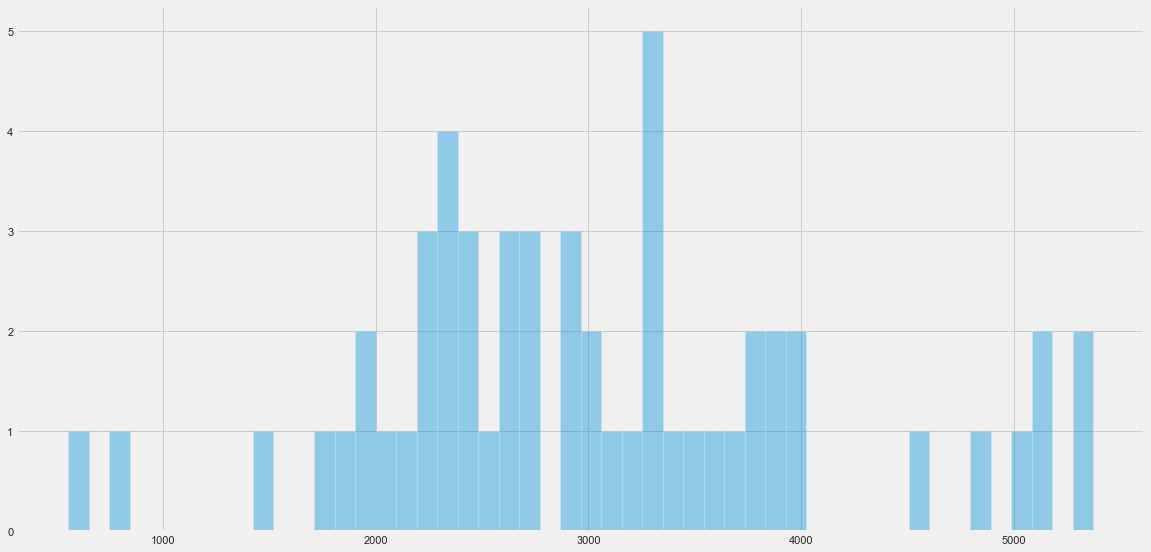

In [105]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [106]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [107]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN VOLCKER.  The  meeting can  come  to  order,  gentlemenand  lady.  We  have  a  lot  of  business  to  dispose  of  at  the  start  and Iwill  try  to  find my agenda,  if  you will  excuse me a moment.  We  havethe  election  of  officers.  First  of  all,  we  have  the  election  of  theChairman--I  keep getting  reminded  that  this  position  is  not  statutory--and we need a nomination.

[SECTION]

MR. SCHULTZ.  Mr. Chairman, after  great  soul-searching untillate  last  night, and  contrary  to  the exhortations  of  many peoplearound this  table,  I have decided  to  nominate  Paul  Volcker as  Chairmanof  the  FOMC!

[SECTION]

CHAIRMAN VOLCKER.  Do we  have  a  second?

[SECTION]

MR. PARTEE.  Second.  You  saved him, Fred!

[SECTION]

MR. SCHULTZ.  Pressure will  do  it  every  time!

[SECTION]

CHAIRMAN  VOLCKER.  Is  there  an  objection?  I shouldn't put  itthat  way!Chairman.

[SECTION]

MR. TIMLEN.  I move  that  the  nominations be  closed.

[SECTION]

CHAIRMA

In [108]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  23
Shape of the dataframe:  (282, 13)


In [109]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,42079,NaN,NaN,None,None,None,MR. STERNLIGHT. [Statement--see Appendix.][SECTION]CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?[SECTION]MR. STERNLIGHT. That was for all of '79...,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,37058,NaN,NaN,None,None,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,22398,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excu...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will exc...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excu..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,19780,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us to...","[CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us t...","CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us to..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,22714,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes.[SECTION]MR. SCHULTZ. So moved.[SECTION]CHAIRMAN VOLCKER. Do we have a second?[SECTION]MS. TEE...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes., MR. SCHULTZ. So moved., CHAIRMAN VOLCKER. Do we have a second?, MS. TEETERS. Second., CHAI...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes.\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88840,0.0,0.0,2014-07-30,0.0,0.0,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but b...","[CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but ...","CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both S

In [110]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,42079,NaN,NaN,None,None,None,MR. STERNLIGHT. [Statement--see Appendix.][SECTION]CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?[SECTION]MR. STERNLIGHT. That was for all of '79...,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,37058,NaN,NaN,None,None,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out ...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,22398,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excu...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will exc...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excu..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,19780,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us to...","[CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us t...","CHAIRMAN VOLCKER. Can we come to order, ladies andgentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us to..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,22714,NaN,NaN,None,None,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes.[SECTION]MR. SCHULTZ. So moved.[SECTION]CHAIRMAN VOLCKER. Do we have a second?[SECTION]MS. TEE...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes., MR. SCHULTZ. So moved., CHAIRMAN VOLCKER. Do we have a second?, MS. TEETERS. Second., CHAI...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. Weneed to approve the minutes.\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,meeting_script,1982-02-02,FOMC Meeting Transcript,other,51549,NaN,NaN,None,None,None,"MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL. [Statements andrelated charts--see Appendix.][SECTION]CHAIRMAN VOLCKER. Do we have any comments or questions onhow these people see ...","[MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL. [Statements andrelated charts--see Appendix.], CHAIRMAN VOLCKER. Do we have any comments or questions onhow these people see thing...","MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL. [Statements andrelated charts--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have any comments or questions onhow these peop..."
19,meeting_script,198

(282, 13)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

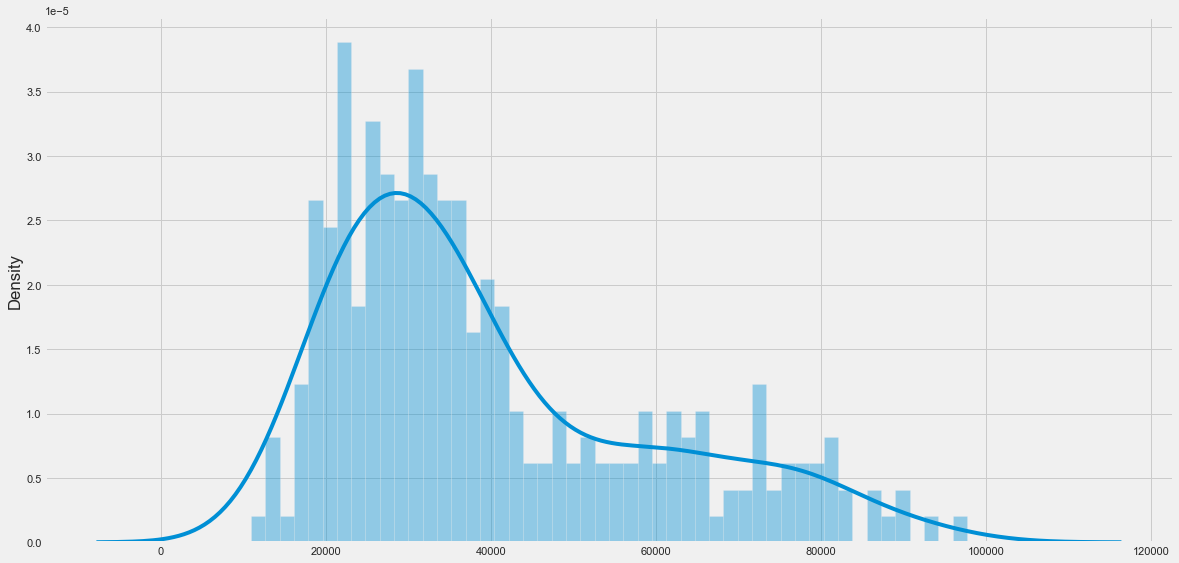

In [111]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [112]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

0it [00:00, ?it/s]

not matched:  SPEAKER(?).  If  it  wasn't a coincidence,  it's  wonderful.
1980-01-09

not matched:  [CHAIRMAN VOLCKER].  If  it  was  far off,  the staff would sayit  was a coincidence!
1980-01-09

not matched:  [CHAIRMAN VOLCKER.  Mr. Willes.]
1980-01-09

not matched:  SPEAKER(?).  Yes,  I'd do  that  too, but we  still  don't knowwhat  the  limits  are.  I don't  think we know the magnitude  of  theproblems  yet  and at what point  the problems become  a policy decisionrather  than a technical  adjustment.1/8-9/80-17-
1980-01-09

not matched:  MR. KICHLINE(?).  Well,  that's part  of  it,  but  it's not  amajor cranking up  of  the  tandem plan.  As you know, the budgetaryimpact  there  is  quite variable;  it  depends  on when the  governmentsells  those mortgages.  It's  an  interest  [subsidy]  that  ultimatelyshows  up  in  the  federal  expenditures.  On the  authorizations,  that's  adifficult  question because we  have built  in  a significant  increase  indefense  expenditu

not matched:  SPEAKER(?).  Yes.
1980-09-16

not matched:  MR. WINN(?).  Don't we have  to  have a discount rateassumption, though,  to make  that  borrowing assumption?
1980-09-16

not matched:  SPEAKER(?).  That's what  he said.
1980-09-16

not matched:  SPEAKER(?).  August-December.
1980-09-16

not matched:  SPEAKER(?).  You're  an awfully  small person!
1980-09-16

not matched:  MR. AXILROD(?).  Mr.  Chairman, the staff  [unintelligible]  ifyou adopted 6-1/2  percent  [for M-1B].
1980-09-16

not matched:  SPEAKER(?).  And 8-3/4  percent  at  least  [for M2].
1980-09-16

not matched:  SPEAKER(?).  Right.
1980-09-16

not matched:  MR. ALTMANN.Chairman Volcker Vice Chairman Solomon Governor Gramley President Guffey President  Morris Governor Partee Governor Rice President  Roos Governor Schultz Governor Teeters Governor Wallich President  Winn YesYesYesNoYesYesYesNoYesYesNoNo
1980-09-16

not matched:  SPEAKER(?).  So moved.
1980-09-16

not matched:  SPEAKER(?).  Seconded.
1980-09-16

n

1981-05-18

not matched:  SPEAKER(?).  Ask  for  a vote.
1981-05-18

not matched:  SPEAKER(?).  If  it's  "or lower."
1981-05-18

not matched:  SPEAKER(?).  Okay, I'll  go with that  rate.5/18/81-55-
1981-05-18

not matched:  SPEAKER(?).  Well,  what's the  alternative--"somewhat  lower"?
1981-05-18

not matched:  SPEAKER(?).  Just voting members?
1981-05-18

not matched:  SPEAKER(?).  Do you prefer  it?
1981-05-18

not matched:  SPEAKER(?). [Not]  including you.
1981-05-18

not matched:  SPEAKER(?).  No,  I was  going to  vote--
1981-05-18

not matched:  SPEAKER(?).  M2?
1981-05-18

not matched:  SPEAKER(?).  M2  is  6-1/2  percent.
1981-05-18

not matched:  MR. ALTMANN.Chairman Volcker Vice Chairman Solomon President Boehne President  Boykin President  Corrigan Governor Gramley Governor Partee Governor Rice Governor Schultz Governor Teeters Governor Wallich President Winn YesYesYesYesYesYesYesYesYesYesYesYes
1981-05-18

not matched:  SPEAKER(?).  What's  the date?
1981-05-18

not ma

not matched:  MR.  CORRIGAN(?).  Not  I.
1982-07-01

not matched:  SPEAKER(?).  I'll  agree  with  it.
1982-07-01

not matched:  SPEAKER(?).  But  they're  not--
1982-07-01

not matched:  SPEAKER(?).  That's  a profane  remark, Henry!
1982-07-01

not matched:  SPEAKER(?).  So  moved.
1982-08-24

not matched:  SPEAKER(?).  Second.
1982-08-24

not matched:  SPEAKER(?).  So  moved.
1982-08-24

not matched:  SPEAKER(?).  Second.
1982-08-24

not matched:  SPEAKER(?).  I've  heard  that  too,  Chuck,  from  businessmen  inour  area.
1982-08-24

not matched:  SPEAKER(?).  That's  what  we  are  doing.
1982-08-24

not matched:  SPEAKER(?).  If  not  100  percent  of  the  businesses.
1982-08-24

not matched:  SPEAKER(?).  Yes.
1982-08-24

not matched:  SPEAKER(?).  Yes.
1982-08-24

not matched:  SPEAKERS(?).  Yes.
1982-08-24

not matched:  SPEAKER(?).  Or  four.
1982-08-24

not matched:  SPEAKER(?).  Yes.
1982-08-24

not matched:  SPEAKER(?).  Use  both?
1982-08-24

not matched:  SPEAKER(?).  

not matched:  SPEAKER(?).  Make  it  2 to  11!
1983-07-13

not matched:  SPEAKER(?).  No  one  feels  all  that  strongly about  it.
1983-07-13

not matched:  SPEAKER(?).  Let's  take  a vote.
1983-07-13

not matched:  MR.  BERNARD.Chairman Volcker Vice  Chairman  Solomon Governor  Gramley President  Guffey President  Keehn Governor  Martin President  Morris YesYesYesYesYesYesNo,  on the  grounds  that  Idon't  think we  ought  to  have  guidelines for  Ml  and M2Governor  Partee Governor  Rice President  Roberts Governor  Teeters Governor  Wallich YesYesYesYesYes
1983-07-13

not matched:  SPEAKER(?).  Make  it  short.
1983-07-13

not matched:  SPEAKER(?).  The  Treasury.
1983-07-13

not matched:  SPEAKER(?).  About  $200  million.
1983-07-13

not matched:  SPEAKER(?).  No.
1983-07-13

not matched:  SPEAKER(?).  They  never  drew on--
1983-07-13

not matched:  END OF  MEETING
1983-07-13

not matched:  [CHAIRMAN VOLCKER.  Questions?]
1983-08-23

not matched:  SPEAKER(?).  What  about  t

not matched:  SPEAKER(?).  In  the  Bluebook.
1984-01-31

not matched:  SPEAKER(?).  In  1982.
1984-01-31

not matched:  SPEAKER(?).  Well,  that  has  been  a  continuing  problem allalong.  But  it  is  true  that  there  is  a clear  expectation  ofinflationary  pressures  later  this  year.
1984-01-31

not matched:  MR.  BERNARD.Chairman Volcker Vice  Chairman  Solomon Governor  Gramley President  Guffey President Keehn Governor  Martin President Morris Governor  Partee Governor  Rice President Roberts Governor  Teeters Governor  Wallich YesYesYesYesYesYesYesYesYesYesYesYes
1984-01-31

not matched:  MR.  BERNARD.Michael  Prell;Charles  Siegman;  andJoseph  Zeisel.Associate  Economists  from the  Reserve  Banks:Joseph  Burns;John M.  Davis;Richard  Davis;Richard  Lang;  andGary  Stern.
1984-03-27

not matched:  SPEAKER(?).  Let's  bid!
1984-03-27

not matched:  SPEAKER(?).  So  move.
1984-03-27

not matched:  SPEAKER(?).  So  move.
1984-03-27

not matched:  SPEAKER(?).  The  Blueboo

not matched:  SPEAKER(?).  You  don't  need  it.5/21/85-36-
1985-05-21

not matched:  SPEAKER(?).  We  could  still  get  some  borrowing  in  New York
1985-05-21

not matched:  SPEAKER(?).  Yes,  I think that--
1985-05-21

not matched:  SPEAKER(?).  "April  performance."
1985-05-21

not matched:  SPEAKER(?).  "In  light  of April."
1985-05-21

not matched:  SPEAKER(?)  Well,  in both  cases  it  ought  to  be  "might"  sothat we  don't  get  trapped.
1985-05-21

not matched:  SPEAKER(?).  Probably you.
1985-05-21

not matched:  SPEAKER(?).  Only  emergency thrift  borrowing.
1985-05-21

not matched:  SPEAKER(?).  So  it  is  pretty  good.
1985-05-21

not matched:  SPEAKER(?).  Yes,  that's  right.
1985-05-21

not matched:  MR.  BERNARD.Chairman Volcker Vice  Chairman  Corrigan President  Balles President  Black President  Forrestal YesYesYesNoYes5/21/85 -45-Governor  Gramley President  Keehn Governor Martin Governor  Partee Governor  Rice Governor  Seger Governor Wallich YesYesYesYe

not matched:  SPEAKER(?).  I think that's  the  one.12/15-16/86changes  here!know--
1986-12-16

not matched:  MR.BERNARD.Chairman  Volcker Vice  Chairman  Corrigan Governor  Angell President  Guffey Governor  Heller President  Horn Governor  Johnson President  Melzer President  Morris Governor  Seger YesYesYesYesYesYesYesYesYesYes
1986-12-16

not matched:  SPEAKER(?). [Unintelligible].
1987-02-11

not matched:  MR. HELLER(?).  Oh,  I understand that.
1987-02-11

not matched:  SPEAKER(?).  Yes.
1987-02-11

not matched:  SPEAKER(?).  This  Friday.
1987-02-11

not matched:  MR.  BERNARD.Chairman  Volcker Vice  Chairman  Corrigan Governor  Angell President  Guffey Governor  Heller Governor  Johnson President Keehn President Melzer President Morris Governor  Seger YesYesYesYesYesYesYesNoYesYes2/10-11/87-56-
1987-02-11

not matched:  SPEAKER(?).  That's  how  I would  like  it.
1987-02-11

not matched:  SPEAKER(?).  Yes.
1987-02-11

not matched:  SPEAKER(?).  It  does  to me.
1987-02-11

n

not matched:  MR. BERNARD.President  Boehne President Boykin Governor  Heller Governor  Johnson President Keehn Governor  Kelley Governor  Seger President  Stern InInInInOutInInIn
1987-12-16

not matched:  MR.  BERNARD.Chairman Greenspan Vice  Chairman  Corrigan Governor  Angell President  Boehne President  Boykin Governor  Heller Governor  Johnson President Keehn Governor  Kelley Governor  Seger President  Stern YesYesYesYesYesYesNoYesYesNoYes
1987-12-16

not matched:  SPEAKER(?).  Mike,  the  pattern  of  inventories  is  prettycritical  for  the  forecast  and  I think you've  made  an  effective  casethat  we  are  not  going to  go  through what  is  considered  a drasticinventory  cycle.  But  the  thing that  strikes  me  is  that,  really,  thisis  almost  the  best  of  all  possible worlds  in  nonfarm inventories  wherethere  is  basically no  cycle.  And  I wonder  if  it's  more  likely  thatyou would have  a greater  reaction  in  terms  of  production than  whatyou've  s

not matched:  SPEAKER(?).  Third.
1988-09-20

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor  Angell President Black President  Forrestal Governor  Heller President  Hoskins Governor  Johnson Governor Kelley Governor  LaWare President Parry Governor Seger YesYesYesYesYesYesYesYesYesYesYesYes
1988-09-20

not matched:  SPEAKER(?).  Second.
1988-11-01

not matched:  MR. PARRY.Sure.11/1/88
1988-11-01

not matched:  SPEAKER(?).  It  doesn't  look too  great,  like  the  economycertainly--
1988-11-01

not matched:  SPEAKER(?).  Real  estate  gets  it,  too.
1988-11-01

not matched:  SPEAKER(?).  We've  bought  it!
1988-11-01

not matched:  SPEAKER(?).  What's  the  biggest  share?
1988-11-01

not matched:  SPEAKER(?).  I'll  move.
1988-11-01

not matched:  SPEAKER(?).  Second.
1988-11-01

not matched:  SPEAKER(?).  What  about  1990?
1988-11-01

not matched:  SPEAKER(?).  Maybe  you can  help  solve  the problem  by tellingus  what  1990  looks  like;  that 

not matched:  SPEAKER(?).  Sure.
1989-12-19

not matched:  SPEAKER(?).  We'll  have  different  voting members  next  year.
1989-12-19

not matched:  MR.  BERNARD.Chairman Greenspan Vice  Chairman  Corrigan Governor  Angell President  Guffey Governor  Johnson President Keehn Governor Kelley Governor  LaWare President Melzer Governor  Seger President  Syron YesYesNoYesYesYesYesYesNoYesYes
1989-12-19

not matched:  MR.  [STERN(?)]  We  don't  have  a difference  in  interpretation.
1990-02-07

not matched:  MR. BERNARD.
1990-02-07

not matched:  SPEAKER(?).  I'm  ready  for  lunch!
1990-02-07

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman Corrigan YesYes2/6-7/90-41-Governor  Angell President  Boehne President  Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern NoYesYesYesYesYesYesNoYes
1990-02-07

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boyk

not matched:  SPEAKER(?).  I'd  go  now.11/5/91-41-
1991-11-05

not matched:  SPEAKER(?).  So  moved.
1991-12-17

not matched:  SPEAKER(?).  Second.12/17/91
1991-12-17

not matched:  SPEAKER(?).  Second.
1991-12-17

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman Corrigan Governor  Angell President  Black President  Forrestal President  Keehn Governor  Kelley Governor  LaWare Governor  Lindsey Governor  Mullins President  Parry Governor  Phillips YesYesYesYesYesYesYesNoYesYesYesYes
1991-12-17

not matched:  SPEAKER(?).  Second.
1992-02-05

not matched:  MR.  BERNARD.Secretary and  Economist,  Donald  Kohn;Deputy  Secretary, Normand  Bernard;Assistant  Secretary,  Joseph  Coyne;Assistant  Secretary,  Gary Gillum;General  Counsel,  Virgil  Mattingly;Deputy  General  Counsel,  Ernest  Patrikis;2/4-5/92Economist,  Michael  Prell;Economist,  Edwin Truman;Associate Economists  from  the  Board:David Lindsey;Larry  Promisel;Charles  Siegman;Thomas  Simpson;  andDavid  Stockto

not matched:  SPEAKER(?).  Citicorp.
1993-07-07

not matched:  SPEAKER(?).  No.
1993-07-07

not matched:  SPEAKER(?).  Second.
1993-07-07

not matched:  SPEAKER(?).  Fudge!
1993-07-07

not matched:  MR. BERNARD.Chairman Greenspan YesActing Vice  Chairman Mullins  Yes7/6-7/93-65-Governor Angell President  Boehne President  Keehn Governor Kelley Governor  LaWare Governor Lindsey President McTeer First Vice  President Oltman Governor  Phillips President  Stern YesYesYesYesYesYesYesYesYesYes
1993-07-07

not matched:  MR. BERNARD.YesChairman Greenspan Acting Vice Chairman Mullins  YesGovernor Angell President  Boehne President  Keehn Governor Kelley Governor LaWare Governor Lindsey President McTeer First  Vice  President  Oltman Governor Phillips President  Stern NoYesYesYesYesYesYesYesYesYes
1993-07-07

not matched:  SPEAKER(?).  Second.
1993-08-17

not matched:  SPEAKER(?).  So move.
1993-08-17

not matched:  MR. BERNARDChairman  Greenspan Vice  Chairman McDonough Governor Angell Preside

not matched:  SPEAKER(?).  If  the  System  is  not participating  in  theseoperations,  that's  going  to  have  some  effect  in  itself  on  the way theTreasury views  the  operations--
1994-11-15

not matched:  SPEAKER(?).  And at  a profit.
1994-11-15

not matched:  MR. BOEHNE(?).  Move approval.
1994-11-15

not matched:  SPEAKER(?).  Second.
1994-11-15

not matched:  MR. BERNARD:Chairman Greenspan Vice Chairman McDonough Governor Blinder President Broaddus President Forrestal President Jordan Governor Kelley Governor  LaWare Governor  Lindsey President Parry Governor Phillips Governor Yellen ApproveApproveApproveNoApproveApproveApproveApproveApproveApproveApproveApprove
1994-11-15

not matched:  SPEAKER(?).  No  objection.
1994-11-15

not matched:  END OF MEETING
1994-11-15

not matched:  SPEAKER(?).  Second.
1994-12-20

not matched:  SPEAKER(?).  The  flood gate was  it?
1994-12-20

not matched:  SPEAKER(?).  A  less-than-successful building project.
1994-12-20

not matched:  MR

not matched:  END OF MEETING
1996-05-21

not matched:  SPEAKER(?)  Second.
1996-07-03

not matched:  SPEAKER(?).  Instead of  choosing,  let's  use  all  of  them.
1996-07-03

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Boehne President Jordan Governor Kelley Governor Lindsey President McTeer Governor Meyer Governor Phillips Governor Rivlin President  Stern Governor Yellen YesYesYesYesYesNoYesYesYesYesYesNo
1996-07-03

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman McDonough President  Boehne President  Jordan Governor  Kelley Governor  Lindsey President  McTeer Governor Meyer Governor  Phillips Governor  Rivlin President  Stern Governor  Yellen YesYesYesYesYesYesYesYesYesYesNoYes
1996-07-03

not matched:  SPEAKER(?).  They have  their  own printing press!  [Laughter]
1996-07-03

not matched:  END OF MEETING
1996-07-03

not matched:  SPEAKER(?).  August  22.
1996-08-20

not matched:  SPEAKER(?).  That's  a pretty good  question.  Do you

not matched:  SPEAKER(?).  I nominate President McDonough of the New York Fed. 
1999-02-03

not matched:  SPEAKER(?).  It doesn’t rhyme. 
1999-02-03

not matched:  SPEAKER(?).  Let’s do it tomorrow.  Why wait? 
1999-02-03

not matched:  SPEAKER(?).  But we are not required to say anything? 
1999-02-03

not matched:  END OF MEETING
1999-02-03

not matched:  END OF MEETING
1999-03-30

not matched:  END OF MEETING
1999-05-18

not matched:  SPEAKER(?).  That’s a good answer. 
1999-06-30

not matched:  END OF MEETING
1999-06-30

not matched:  END OF MEETING
1999-08-24

not matched:  SPEAKER(?).  You don’t have to!  [Laughter] 
1999-10-05

not matched:  SPEAKER(?).  That’s fine! 
1999-10-05

not matched:  SEVERAL(?).  No, no. 
1999-10-05

not matched:  END OF MEETING
1999-10-05

not matched:  SPEAKER(?).  Pass them to me. 
1999-11-16

not matched:  END OF MEETING
1999-11-16

not matched:  SPEAKER(?).  So, it’s only 20! 
1999-12-21

not matched:  SPEAKER(?).  A true sailor! 
1999-12-21

not m

not matched:  MR. STOCKTON.  Actually, this is an issue that Vincent will be covering shortly in his remarks.  But looking out beyond the Greenbook forecast interval—again, I caution you to take these figures with an enormous grain of salt and maybe an entire salt mine—we would expect close to another 100 basis points of tightening to be necessary in 2004.  Combined with the tightening we’re now assuming in 2003, that additional tightening in 2004 brings growth roughly in line with potential, stabilizes the unemployment rate at just a little above 5 percent, and holds the core PCE inflation rate at roughly 1½ percent.  So the design of this forecast was that it was possible for you to achieve that particular equilibrium going out beyond the Greenbook forecast period with the amount of tightening we built in here.  Obviously, there are associated strategic questions about tightening earlier versus later, and Vincent will be talking about some of those issues in his presentation. 
2002-

not matched:  MR. PARRY.  No, it has not.  But both sides made concessions to reach an agreement on technology, and that has been the major stumbling block.  There are other issues, but that’s the major one.  Although talks still could break down over pensions and arbitration, clearing the technology hurdle substantially eased tensions between the two parties.  That being said, operations at West Coast ports have yet to return to normal.  The pace of work remains well below capacity at ports throughout the West.  And in some ports, the backlogs of container ships have hardly shrunk at all since the workers returned in early October.  This is particularly true at LA/Long Beach, which of course is the largest port.  Only the port of Seattle has completely recovered from the lockout, having no ships queued in the harbor at the present time.  More generally, congestion, truck and railcar imbalances, and periodic work disruptions have delayed deliveries and shipments and boosted freight co

not matched:  MR. POOLE.  Thank you, Mr. Chairman.  What we hear repeatedly around the District are phrases such as “muddling along,” “on hold,” and “wait and see.”  Bank loan demand is flat.  It’s very difficult to know—I don’t think anybody can tell—how much of what we’ve been observing is a consequence of war fears and how much of it reflects underlying uncertainties.  I’ve been pressing my contacts about their capital spending plans and in particular trying to find out if people are thinking ahead to the expiration of the tax incentives in September of next year.  In general, people comment that they are not taking that into account yet, and capital spending is flat.  My UPS contact says that UPS capital expenditures are for repairing or replacing equipment as necessary but there is no growth in the company’s capital expenditures spending.  However, my FedEx contact said that FedEx does plan to buy trucks very aggressively to take advantage of the investment incentives.  He expect

2003-09-15

not matched:  CHAIRMAN GREENSPAN.  Governor Olson. 
2003-09-15

not matched:  CHAIRMAN GREENSPAN.  Governor Kohn. 
2003-09-15

not matched:  MR. POOLE.  A point that I don’t think has come up yet is the fact that we’re talking to a number of different audiences.  With regard to our political accountability—talking to the Congress and the general public—I think we do just fine, and I believe the current publication schedule for the minutes fully serves that audience.  In terms of talking to the markets, Cathy and Jamie mentioned the traders, and I’d certainly like to draw a distinction between the traders and the portfolio managers.  The traders make their money from reading tea leaves, hot tips, and understanding little nuances.  What they really want to know is what our thinking is about the federal funds rate at the next meeting or the possibility of intermeeting changes in the rate.  They don’t very much care about why or the underlying reasons.  To speak to the point

not matched:  MR. BERNANKE.  Thank you, Mr. Chairman.  The economic news since our last meeting has been heartening.  The odds that we have begun a strong and sustainable expansion have risen significantly.  Because of the rise in growth, we’re going to see even more op-ed articles, wire stories, and editorials opining that the Fed needs to tighten soon to avoid a repeat of 1980s-style inflation.  The Wall Street Journal today has an editorial along those lines.  I believe these critics are not particularly well informed and that, as a Committee, we should continue to remain patient and not choke off growth unnecessarily.  In particular, though of course we have to be vigilant to detect any change in the inflation trend, the odds of inflation rising significantly any time soon from its current very low level seem small.  Let me make a few points.  First, those on the Street and elsewhere who lately have been worrying about inflation have tended to point primarily to raw materials pric

not matched:  VICE CHAIRMAN GEITHNER.  Thank you, Mr. Chairman.  The balance of risks has changed since our last meeting, and the changes seem largely favorable.  The outlook for growth seems stronger, with less downside risk.  Inflation risks appear more balanced around a higher but still quite moderate path. The economy of the Second District has continued to improve.  The pace of the expansion has increased.  Where we were weaker earlier in the year, we are now stronger.  There is less caution in the commentary.  Employment is increasing quite rapidly, and businesses report plans to increase hiring further in the months ahead.  We hear, as do others, lots of reports about skills mismatches and difficulty in filling positions.  Inflation in our region is higher than the national average—about double—despite what seem to be higher levels of resource slack and a later onset of recovery.  Much of the rise in prices is due to housing, but business contacts in the District report higher 

not matched:  MR. REINHART.  Yes. end of October look? futures curve, it’s in fact— 
2004-11-10

not matched:  CHAIRMAN GREENSPAN.  It’s terribly important for us to get judgments on what the TIPS is showing.  We can always talk about its liquidity or say that it’s X or Y.  Some day we’ll look back and say that the TIPS market was giving us signals and we had too many excuses as to why we weren’t looking at it. 
2004-11-10

not matched:  SPEAKER(?).  Yes.  I so move. 
2004-11-10

not matched:  MS. JOHNSON.  Over the intermeeting period, news about foreign economic developments has generally been somewhat disappointing, and we have edged down our outlook for real GDP growth abroad in response.  The downward revision is largest for the third quarter, 0.4 percentage point, as growth appears to have been below our expectations in Japan, Europe, and emerging Asia other than China, where we were surprised on the upside as we were also to a slight extent in Latin America.  For the current 

not matched:  SPEAKER(?).  Page 14, Mr. Chairman. 
2005-06-30

not matched:  CHAIRMAN GREENSPAN.  Let me ask that the  Board of Governors repair to my office for the consideration of other subjects. [Recess]  
2005-06-30

not matched:  PARTICIPANT.  I second. 
2006-01-31

not matched:  MR. REINHART.  But convexity is a quadratic and starts about at the twenty-year maturity pulling down yields.  That’s why typically the thirty-year yield is below the twenty-year yield.  When you get out to the fifty-year, then the effect of convexity is even more pronounced. 
2006-01-31

not matched:  MS. MINEHAN.  I agree with you, but the fund managers that I have talked with would frame the problem in the context of increasing pressure from the outside. 
2006-01-31

not matched:  MR. STRUCKMEYER.  Well, the 2001 effect was the incorporation of the NAICS classifications into the payroll survey.  So it was just a methodological change that was realized. 
2006-01-31

not matched:  MR. SANTOMERO.  

not matched:  CHAIRMAN BERNANKE.  President Fisher.   
2006-06-29

not matched:  MR. FISHER.  Well, actually we have that on our website, Mr. Chairman.  I’d be happy to give you the report.  These are the breakdowns of all the different expenditure components within the PCE. 
2006-06-29

not matched:  MR. STONE.  Thank you, Mr. Chairman.  Economic activity in the Third District is also moderating in the second quarter.  Our pattern is similar to that of the nation, but the District had less acceleration in the first quarter and less deceleration in the second quarter.   Payroll employment growth in our three states is slowing.  The unemployment rate has edged up slightly over the past several months, but the unemployment rate in most of the District’s labor markets is still lower than a year ago.  Our business contacts still report some difficulty in filling open positions, and a quarter of the respondents to a special question in our Business Outlook Survey of Manufacturers say tha

not matched:  CHAIRMAN BERNANKE.  Thank you.  Are there any questions or comments?  Approved without objection.  Next on the agenda is a proposed change to Committee rules.  We received a memo from Scott Alvarez and Debbie Danker, which concerns how a backup would be appointed in case the Desk Manager was unable to serve.  Are there any questions for our colleagues on that memo?   
2007-01-31

not matched:  MR. WASCHER.  The top panel of exhibit 5 summarizes our assumptions about the supply side of the economy.  As indicated in line 1, we assume that potential output growth will edge down over the forecast period, from 2.7 percent in 2006 to 2.5 percent in 2008.  This slowing primarily reflects our assumptions about trend hours growth (line 2), which steps down from about ¾ percent last year to ½ percent in 2008 because of a steepening downward trend in the labor force participation rate and a gradual slowing of population growth.  Although we are comfortable with these assumptions—a

not matched:  MS. DANKER.  I’ll be reading the directive and the risk assessment from page 23 of the Bluebook.  “The Federal Open Market Committee seeks monetary and financial conditions that will foster price stability and promote sustainable growth in output.  To further its long-run objectives, the Committee in the immediate future seeks conditions in reserve markets consistent with maintaining the federal funds rate at an average of around 5¼ percent.” The risk assessment:  “In these circumstances, the Committee’s predominant policy concern remains the risk that inflation will fail to moderate as expected.  Future policy adjustments will depend on the evolution of the outlook for both inflation and economic growth, as implied by incoming information.” Chairman Bernanke   Yes Vice Chairman Geithner    Yes Yes President Hoenig         Yes Governor Kohn            Governor Kroszner        Yes Yes President Minehan        Yes Governor Mishkin         President Moskow         Yes Yes P

not matched:  MS. PIANALTO.  Thank you, Mr. Chairman.  Like many others around the table, my report to this Committee in September indicated a sharp deterioration in business confidence.  My business contacts were concerned about what may happen.  During the intermeeting period I heard less about what may happen and more about what is actually happening.  My contacts who are linked to residential real estate have seen a further and, in some cases, sharp drop-off in business activity.  My banking supervision and regulation staff told me just a few days ago that they’re now seeing a sudden and sizable percentage increase in nonperforming loans at a number of large banking companies in my District.  To be sure, nonperforming loans had been at extremely low levels, and most of the sharp rise can be traced to mortgage and construction development lending.  But I’m now beginning to hear reports that bankers are experiencing some loan performance problems outside their real estate portfolio.

not matched:  MR. LACKER.  I think the political concern you raised and described is a very, very serious one for this institution.  Even if we thought of this ourselves before Senator Dodd and others wrote to us—and apparently it is true that we did—we are never going to be able to convince a broad array of observers that this was not a direct response to a senatorial request.  Given that, I think the perception that we included this and maybe added some other securities as a fig leaf sets just a disastrous precedent.  It would be the use of our balance sheet to circumvent the checks and balances of the constitutional process for legislating about fiscal matters.  I think that the integrity of our independence as an institution relies, to a substantial degree, on our lack of entanglement or our distance from the political fray. I would also question the value of this on the substance.  What we are doing with the TSLF, as Bill’s chart showed, looks as though it has had a big effect on

not matched:  MS. DUKE.  Thank you, Mr. Chairman.  I was advised to speak of things I know, so all of my comments will have to do with commercial banks and the traditional banking operations within those banks.  Also, they are limited to the market area that I operated in.  I was in a large community bank.  The primary competitors were 2 of the top 5 banks and 4 of the top 20 banks.  I hope to expand that on the supervision committee. I guess the major observation I would have is that I can’t see lending growth ever resuming until the market for financial stocks improves.  That market is not going to improve until it is clear that the credit risk is manageable.  I haven’t seen the confidence in banking and banking institutions this low since we were well into the S&L crisis back in the early 1990s.  At the same time, the credit numbers—or at least the commercial banks’ part of the credit numbers—don’t look all that bad.  At this point, we are sharing those credit losses with a number 

not matched:  MR. SICHEL.  You could do these types of cyclical comparison charts either way, dating from the NBER peak or dating from the series-specific peak.  What is done here is to index to the series-specific peak so that you look at each of the path cycles and say when GDP turned down in that cycle.  In many cycles, that is the same as the NBER peak, but in some cycles it is not.  In this cycle, in particular, it came a couple of quarters later.  You could do it the other way—in which case you would see the red line rising first and then coming down.  It is just a different way of presenting the same information. 
2009-01-28

not matched:  MS. DYNAN.  We have asked separately about what they are doing to credit lines.  In fact, more than half are saying that they are reducing credit lines as well.  
2009-01-28

not matched:  MR. SICHEL.  We are interpreting this proposal as a down payment on a permanent change. 
2009-01-28

not matched:  MS. DYNAN.  We do not have a model—or

not matched:  CHAIRMAN BERNANKE.  Why are we doing that instead of mixing new issues and seasoned mortgages? 
2009-04-29

not matched:  MR. NELSON.  No, it is not. 
2009-04-29

not matched:  MS. MOSSER.  One parenthetical comment.  On CMBS, our understanding, in talking to the investors and the syndicators, is that the new-issue CMBS are obviously a substantially smaller pool of possible loans and securitizations than the legacy.  Opening it up to legacy actually makes the larger number seem, at least relative to take-up so far, more possible.  If for some reason we would stop with just the current-sized TALF, I think I at least would be surprised if we got to $400 billion.  But if it is opened up to legacy assets, then the possibility of getting the larger numbers is more likely. 
2009-04-29

not matched:  MR. HOENIG.  Just a question on the maturity on the TALF.  We want to go from three to five years.  That, of course, means that rolling off our balance sheet will be slower.  Is

not matched:  MR. ENGLISH.  Yes.  
2009-09-23

not matched:  MR. LACKER.  Did you say they’re putting it through their standard new product evaluation?  [Laughter]  And finally, a point about term deposits.  You were talking about some features that would make these pretty liquid—they’d be able to pledge them at the discount window and withdraw them without   penalty.  If you make these things really accessible, then I’m not sure why draining reserves and putting them there would have any effect.  Why would you expect that?  Don’t you need some stark, sharp,    constraining differences in order for them to have any sort of monetary effect?   
2009-09-23

not matched:  MR. PLOSSER.  We have no idea what the quantities are going to be, because it’s underbid every  time.  So I don’t quite understand.  If we’re not maxing out on the quantities, then we really aren’t setting the quantities.  The market is setting the quantities, and it’s setting the quantities based on a low price that w

not matched:  MR. KOCHERLAKOTA.  Mr. Chairman, I think you, as usual, ably summed up everything that people have said.  The one question I had was about redeeming Treasuries and using the proceeds to buy short-term Treasuries, while at the same time draining reserves.  It seems as though we are somehow in the position of both borrowing and saving at the same time. 
2010-01-27

not matched:  CHAIRMAN BERNANKE.  Without objection.  Thank you.  We will continue tomorrow morning at 8:30 with the presentation by the staff.  Thank you.  There is a reception and a dinner for your convenience available upstairs. [Meeting recessed] 97 of 260 
2010-01-27

not matched:  MR. PALUMBO.  Exhibit 3 turns to the outlook for consumer spending, first by describing some aspects of the substantial financial adjustment—most notably, the “deleveraging”—undertaken by households since the onset of financial turmoil.  As you can see in the top left panel, the personal saving rate shifted up from close to 1 

not matched:  MR. LACKER.  At noon. you.  Have a good trip home. 
2011-03-15

not matched:  CHAIRMAN BERNANKE.  And I was very clear that that is certainly not what we’re   doing, that this is conditional on the factors that we discuss in the statement.  However, I don’t  think this Committee has really thoroughly hashed out whether or not the reaction function that  is embedded in that conditional commitment is a Taylor rule or an attempt at an optimal policy     under commitment or what.  And I think that question is not yet fully resolved.   
2012-03-13

not matched:  CHAIRMAN BERNANKE.  Okay.  We’ll reconvene tomorrow morning at 8:30.    Obviously, if you have any changes in your SEP projections, please provide those as soon as    possible.  A reception is now available upstairs, followed by dinner.  Thank you.  [Meeting recessed]       136 of 260      
2012-12-12

not matched:  CHAIRMAN BERNANKE.  It would affect the timing, right? 
2013-06-19

not matched:  VICE CHAIRMAN DU

not matched:  MR. KOCHERLAKOTA.  Yes.  Thank you, Madam Chair.  I had a comment and a   question.  The comment is that I found these charts about the median dealer purchase   expectations and the expected path of the fed funds rate to be useful.  It would be, I think, also    informative to be presenting information about the distribution of beliefs as well.  I think it would be slightly helpful in getting after some of the concerns about low volatility that we’ve   been hearing, because you’d be getting a little bit of a picture of the distribution of beliefs in the     The question is about the SEP.  The SEP shows a slight amount of tightening.  What are     the staff views on how that would be interpreted by markets?  
2014-06-18

not matched:  MR. POTTER.  The big issue is, they try to put names on each dot, and that makes it   harder for them to work out the particular names they might be interested in when you add   people.  
2014-06-18

not matched:  MS. MESTER.  Yes.  I just

not matched:  MS. BRAINARD.  Since we last met, we’ve had two strong payroll reports, and American consumers are demonstrating more confidence both in their actions and in their expectations, bolstered, in part, by significantly lower prices at the pump.  These are very welcome developments.  But we also see the increasingly resilient growth in the United States taking place against a backdrop of considerable risks to the outlook in several important foreign economies, and the dollar has continued its sharp appreciation.  In addition, progress in moving inflation back up toward our target has been quite limited, even looking through the recent sharp drop in oil prices.  On balance, then, I would say that conditions continue to validate our strategy of ending asset purchases in October—this time for real, or so we hope—while remaining somewhat patient on the removal of monetary accommodation, even as we see the day of liftoff coming, I think, into clearer view. The news from the labor 

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. STERNLIGHT,3,NaN,NaN,None,None,None,[Statement--see Appendix.],"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,10,NaN,NaN,None,None,None,[That was the change in System holdings ofsecurities] since when?,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. STERNLIGHT,5,NaN,NaN,None,None,None,That was for all of '79.,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,25,NaN,NaN,None,None,None,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1206,NaN,NaN,None,None,None,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful...","[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN V...",MR. STERNLIGHT. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings ofsecurities] since when?\n\n[SECTION]\n\nMR. STERNLIGHT. That was f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109599,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,84,0.0,0.0,2017-02-01,0.0,0.5,"Thank you. Okay. I think the main open issue in the statement is the bracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eight people propose removing it. I’...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeti...","CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meetin..."
109600,meeting_script,2014-12-17,FOMC Meeting Transcript,MR. LUECKE,58,0.0,0.0,2017-02-01,0.0,0.5,"This vote, as Chair Yellen indicated, will be on alternative B, depicted on pages 6 and 7 of Bill English’s handout. It will not have the word “somewhat” on line 3. It will also cover the direc...","[CHAIR YELLEN. Good afternoon, everyone. I think we a

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [113]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (109604, 13)
After:  (50832, 13)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

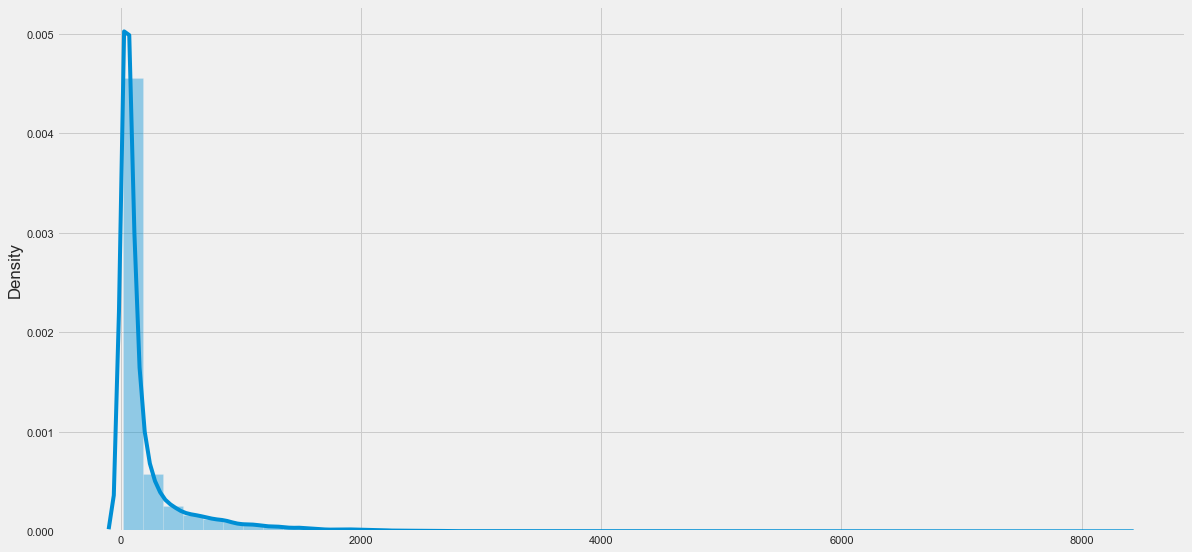

In [114]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [115]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


TypeError: unhashable type: 'Series'

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

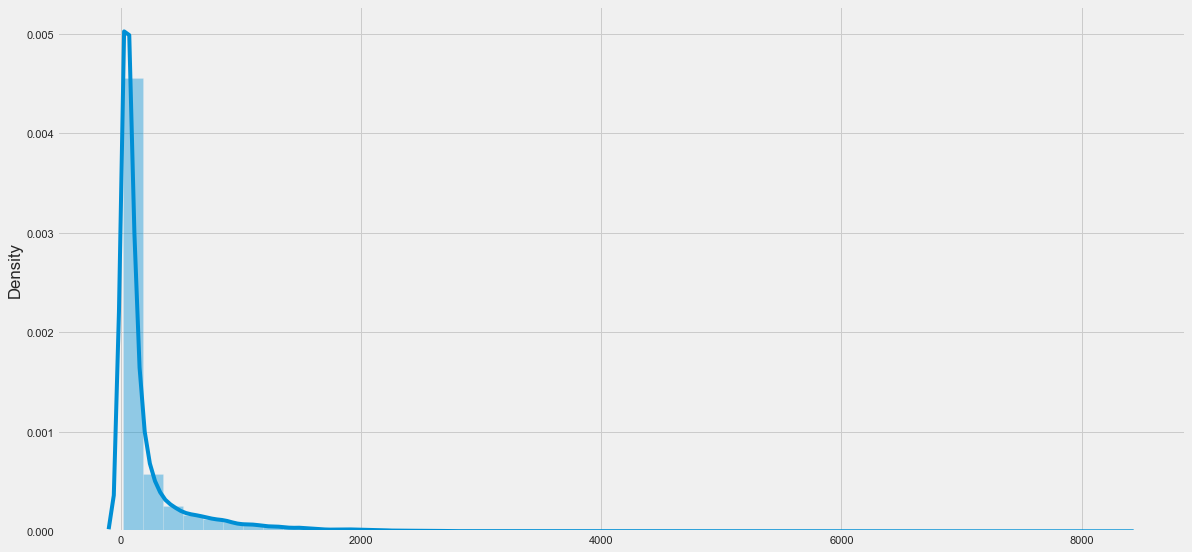

In [116]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [ ]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df

In [ ]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [135]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1607
Shape of the dataframe:  (1607, 13)


In [136]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3334,None,None,1996-07-03,0.0,5.25,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2815,None,None,1996-07-03,0.0,5.25,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2902,None,None,1996-09-24,0.0,5.25,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,2110,None,None,1996-09-24,0.0,5.25,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2301,None,None,1996-11-13,0.0,5.25,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,speech,2022-10-12,Managing the Promise and Risk of Financial Innovation,Vice Chair for Supervision Michael S. Barr,2227,None,None,2022-11-02,NaN,NaN,"The Federal Reserve, the central bank of the 

(1607, 13)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

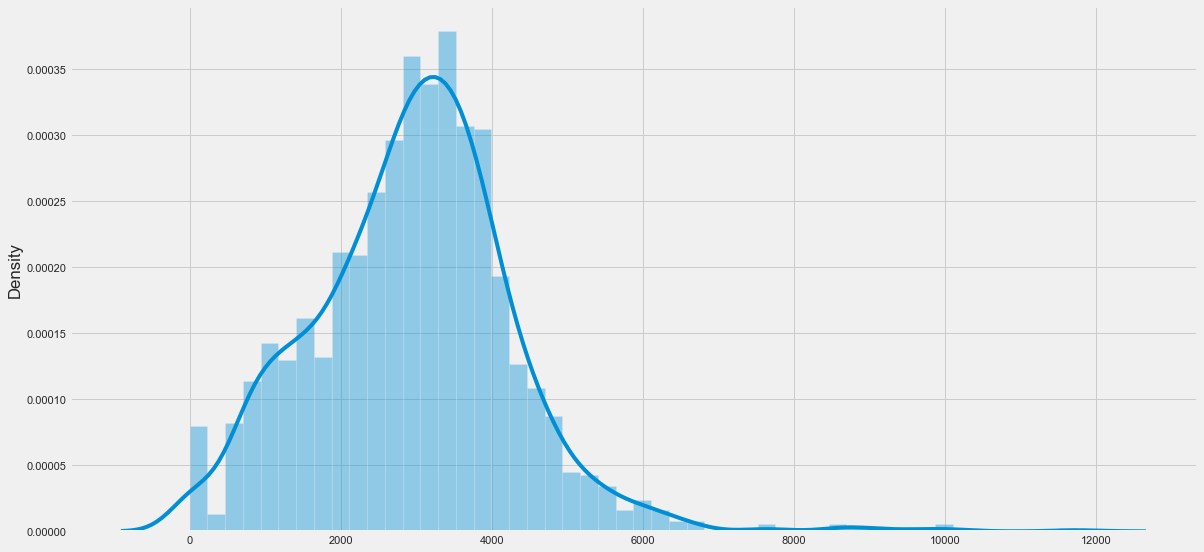

In [137]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [138]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

2

In [139]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


  0%|          | 0/1607 [00:00<?, ?it/s]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3228,None,None,1996-07-03,0.0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2790,None,None,1996-07-03,0.0,5.25,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,None,None,1996-09-24,0.0,5.25,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1718,None,None,1996-09-24,0.0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2133,None,None,1996-11-13,0.0,5.25,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,speech,2022-10-12,Managing the Promise and Risk of Financial Innovation,Vice Chair for Supervision Michael S. Barr,2054,None,None,2022-11-02,NaN,NaN,"Thank you, Chris, and thank you for the invitation to speak to you today about 

In [145]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson!=None and not isinstance(row['speaker'], float) and chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(445, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3228,None,None,1996-07-03,0.0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1718,None,None,1996-09-24,0.0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2315,None,None,1996-11-13,0.0,5.25,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be clear t...,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,1118,None,None,1996-11-13,0.0,5.25,I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service. I am particularly honored by the company that I keep as a winner of thi...,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1615,None,None,1996-11-13,0.0,5.25,The Conference Board has been an important institution in my life. It was where I started as an economist. It was where I came into contact with a business world I had never known before. The y...,"[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,speech,2022-05-24,Video,Jerome Powell,451,None,None,2022-06-15,1.0,1.5,"The National Center for American Indian Enterprise Development has been a strong and consistent partner to the Federal Reserve, collaborating with us on small business COVID surve

### Split contents to max 200 words

In [146]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df

  0%|          | 0/445 [00:00<?, ?it/s]

(7186, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,0.0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,0.0,5.25,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,0.0,5.25,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,0.0,5.25,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,0.0,5.25,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,speech,2022-08-26,Monetary Policy and Price Stability,Jerome Powell,200,None,None,2022-09-21,NaN,NaN,based measures as well But that is not grounds for complacency with inflation having run well above our goal for some time If the public expects that inflation will remain low an

### Filter out by keyword

In [147]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

(225, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,None,None,1996-11-13,0.0,5.25,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
1,speech,1996-12-06,Social security,Alan Greenspan,253,None,None,1996-12-17,0.0,5.25,"While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....","[While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
2,speech,1997-01-14,Central banking and global finance,Alan Greenspan,133,None,None,1997-02-05,0.0,5.25,"In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at le...","[In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at l...","\n\n[SECTION]\n\nCentral Banking and Global Finance\n\n[SECTION]\n\nMr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck,\r\nProfessor Peeters, ladies and gentlemen, it ..."
3,speech,1997-02-21,Government regulation and derivative contracts,Alan Greenspan,212,None,None,1997-03-25,1.0,5.5,"In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...","[In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identifie...","I am pleased to participate once again in the Federal Reserve Bank of Atlanta's annual Financial Markets Conference. As in previous years, the Reserve Bank has developed a conference program that..."
4,speech,1997-04-29,G-7 economic summit meeting,Alan Greenspan,142,None,None,1997-05-20,0.0,5.5,"In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at ...","[In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at...","\n\n[SECTION]\n\nIt is a pleasure to be here today.\n\n[SECTION]\n\nI will take this occasion to offer some thoughts related to the upcoming G-7 economic summit meeting, which will be held in Denv..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,speech,2020-10-06,Recent Economic Developments and the Challenges Ahead,Jerome Powell,413,None,None,2020-11-05,0.0,0.0,"The Pre-COVID EconomyAs the coronavirus spread across the globe, the U.S. economy was in its 128th month of expansionâthe longest in our recorded historyâand was general

In [148]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [149]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  456
Shape of the dataframe:  (456, 13)


In [150]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,None,None,1996-07-03,0.0,5.25,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,None,None,1996-08-20,0.0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,None,None,1996-08-20,0.0,5.25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,None,None,1996-08-20,0.0,5.25,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,None,None,1996-08-20,0.0,5.25,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,testimony,2022-01-11,Nomination hearing,Chair Jerome H. Powell,1076,None,None,2022-01-26,0.0,0.0,"The Federal Reserve, the central bank of the United States, provides the nation w

(456, 13)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

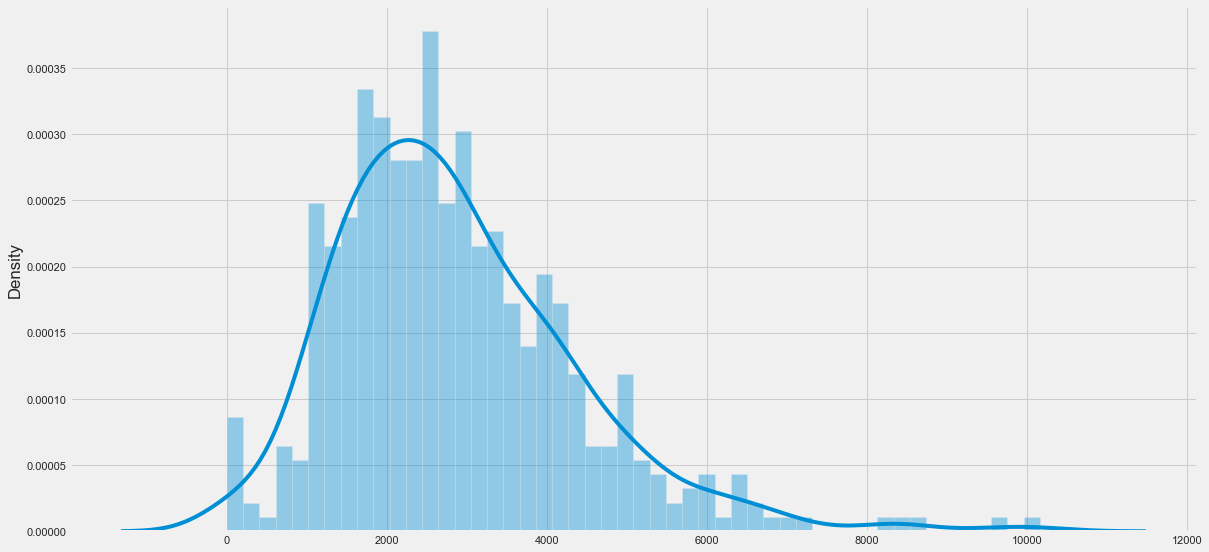

In [151]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [152]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [153]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

  0%|          | 0/456 [00:00<?, ?it/s]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,None,None,1996-07-03,0.0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,None,None,1996-08-20,0.0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,None,None,1996-08-20,0.0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,None,None,1996-08-20,0.0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,None,None,1996-08-20,0.0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,testimony,2022-01-11,Nomination hearing,Chair Jerome H. Powell,654,None,None,2022-01-26,0.0,0.0,"Chairman Brown, Ranking Member Toomey, and other members of the Committee, thank 

In [154]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,None,None,1996-08-20,0.0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,None,None,1996-08-20,0.0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2854,None,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2829,None,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today. The Committee is faced with a number of complex policy issues that will have an important beari...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4234,None,None,1997-03-25,1.0,5.5,"Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,testimony,2021-09-28,Coronavirus and CARES Act,Jerome Powell,931,None,None,2021-11-03,0.0,0.0,"Chairman Brown, Ranking Member Toomey, and other members of the Committee, thank you for the opportunity to discuss the measures we have taken to address the hardship wr

### Split contents to max 200 words

In [155]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df

  0%|          | 0/187 [00:00<?, ?it/s]

(2915, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,0.0,5.25,Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,0.0,5.25,above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,0.0,5.25,be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,0.0,5.25,better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,0.0,5.25,less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,testimony,2022-06-22,Semiannual Monetary Policy Report to the Congress,Jerome Powell,200,None,None,2022-07-27,NaN,NaN,larger and longer lasting than anticipated and price pressures have spread to a b

### Filter out by keyword

In [156]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

(131, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,None,None,1996-08-20,0.0,5.25,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,None,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
2,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,None,None,1997-03-25,1.0,5.5,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
3,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,None,None,1997-03-25,1.0,5.5,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
4,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,1068,None,None,1997-08-19,0.0,5.5,This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,[This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,testimony,2021-06-22,The Federal Reserve&#39;s Response to the Coronavirus Pandemic,Jerome Powell,214,None,None,2021-07-28,0.0,0.0,"Since we last met, the economy has shown sustained improvement. Widespread vaccinations have joined unprecedented monetary and fiscal policy actions in providing strong support to the recovery.

In [157]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [159]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           #meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            #meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          #meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [160]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [161]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
